In [6]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline

/var/folders/2c/r01vghr16hbb2gb9rwm76yn40000gn/T/ipykernel_40716/2937521934.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [7]:

# Environment 
class Environment:    
    def step(self):
        raise NotimplementError
    
class CliffWalking(Environment):
    def __init__(self):
        self.WORLD_HEIGHT = 4
        self.WORLD_WIDTH = 12
        self.START = [3, 0]
        self.GOAL = [3, 11]

    def step(self, state, action):
        i, j = state  # current state
        if action == 0:
            next_state = [max(i - 1, 0), j]
        elif action == 1:
            next_state = [min(i + 1, self.WORLD_HEIGHT - 1), j]
        elif action == 2:
            next_state = [i, max(j - 1, 0)]
        elif action == 3:
            next_state = [i, min(j + 1, self.WORLD_WIDTH - 1)]
        else:
            assert False
        
        reward = -1 
        if (action == 1 and i == 2 and 1 <= j <= 10) or (action == 3 and state == self.START):
            reward = -100
            next_state = self.START
        
        return next_state, reward

In [26]:
np.random.seed(42)
class Agent:
    def __init__(self, env: Environment):
        self.GAMMA = 1 # discount factor 
        self.EPSILON = 0.1 # for exploration
        self.ALPHA = 0.5 # step size 
        self.env = env 

        # ACTION_UP = 0
        # ACTION_DOWN = 1
        # ACTION_LEFT = 2
        # ACTION_RIGHT = 3
        self.ACTIONS = [0, 1, 2, 3]
        self.q_values = np.zeros(
            (self.env.WORLD_HEIGHT, self.env.WORLD_WIDTH, len(self.ACTIONS))
        )

    def choose_action(self, state):
        if np.random.binomial(1, self.EPSILON) == 1:
            return np.random.choice(self.ACTIONS)
        else:
            values_ = self.q_values[state[0], state[1], :]
            return np.random.choice(
                [
                    action_ 
                    for action_, value_ in enumerate(values_)
                    if value_ == np.max(values_)
                ]
            ) # Choose action has max value 

    def sarsa(self, expected=False):
        state = self.env.START # start state 
        action = self.choose_action(state)
        rewards = 0.0 

        while state != self.env.GOAL:
            next_state, reward = self.env.step(state, action)
            next_action = self.choose_action(next_state)
            rewards += reward 
            if not expected:
                target = self.q_values[next_state[0], next_state[1], next_action]
            else:
                # calculate the expected value of new state
                target = 0.0 
                q_next = self.q_values[next_state[0], next_state[1], :]
                best_actions = np.argwhere(q_next == np.max(q_next))
                for action_ in self.ACTIONS:
                    if action_ in best_actions:
                        target += (
                            (1.0 - self.EPSILON) / len(best_actions) + self.EPSILON / len(self.ACTIONS)
                        ) * self.q_values[next_state[0], next_state[1], action_]
                    else:
                        target += (
                            self.EPSILON
                            / len(self.ACTIONS)
                            * self.q_values[next_state[0], next_state[1], action_]
                        )

            self.q_values[state[0], state[1], action] += self.ALPHA * (
                reward + target * self.GAMMA - self.q_values[state[0], state[1], action]
            )

            state = next_state 
            action = next_action

        return rewards 

    def q_learning(self):
        state = self.env.START
        rewards = 0.0 
        while state != self.env.GOAL:
            action = self.choose_action(state)
            next_state, reward = self.env.step(state, action)
            rewards += reward 

            # Q-Learning update
            self.q_values[state[0], state[1], action] += self.ALPHA * (
                reward
                + self.GAMMA * np.max(self.q_values[next_state[0], next_state[1], :])
                - self.q_values[state[0], state[1], action]
            )

            state = next_state

        return rewards 

    def optimal_policy(self):
        optimal_policy = []
        for i in range(0, self.env.WORLD_HEIGHT):
            optimal_policy.append([])
            for j in range(0, self.env.WORLD_WIDTH):
                if [i, j] == self.env.GOAL:
                    optimal_policy[-1].append("G")
                    continue
                bestAction = np.argmax(self.q_values[i, j, :])
                if bestAction == 0:
                    optimal_policy[-1].append("U")
                elif bestAction == 1:
                    optimal_policy[-1].append("D")
                elif bestAction == 2:
                    optimal_policy[-1].append("L")
                elif bestAction == 3:
                    optimal_policy[-1].append("R")
        return optimal_policy

In [27]:
env = CliffWalking()
sarsa_agent = Agent(env)
expected_sarsa_agent = Agent(env)
q_learn_agent = Agent(env)

def simulate(agent, env, episodes=500, runs=50, alg='sarsa'):
    rewards = np.zeros(episodes)
    for _ in tqdm(range(runs)):
        for i in range(episodes):
            if alg == 'sarsa':
                rewards[i] += agent.sarsa()
            elif alg == 'q_learning':
                rewards[i] += agent.q_learning()
            elif alg== 'e-sarsa':
                rewards[i] += agent.sarsa(expected=True)
            else:
                assert False, f"Algorithm {alg} is not valid"
            # rewards[i] += max(sarsa_agent.sarsa(), -100)

    rewards /= runs 

    return rewards

rewards_sarsa = simulate(sarsa_agent, env, alg='sarsa')
rewards_q_learning = simulate(q_learn_agent, env, alg='q_learning')
rewards_expected_sarsa = simulate(sarsa_agent, env, alg='e-sarsa')


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


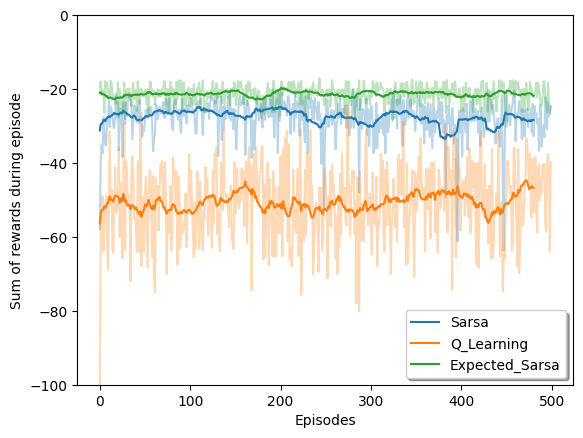

In [28]:
def plot_reward_curves(
    window_size=20,**kwargs
):
    for name, rewards in kwargs.items():
        original, = plt.plot(rewards, alpha=0.3)
        color = original.get_color()
        smoothed_sarse = np.convolve(rewards, np.full((window_size,), 1 / window_size), mode="valid")
        plt.plot(smoothed_sarse, color=color, label=name)

    # plt.savefig("../images/figure_6_4.png")
    plt.xlabel("Episodes")
    plt.ylabel("Sum of rewards during episode")
    plt.ylim([-100, 0])
    plt.legend(shadow=True, fancybox=True)
    plt.show();
    plt.close()

plot_reward_curves(Sarsa=rewards_sarsa, Q_Learning=rewards_q_learning, Expected_Sarsa=rewards_expected_sarsa)

In [29]:
def print_optimal_policy(optimal_policy):
    env = CliffWalking()
    G = nx.DiGraph()

    # Create graph nodes
    for i in range(env.WORLD_HEIGHT):
        for j in range(env.WORLD_WIDTH):
            G.add_node((i, j))

    # Create graph edges based on the policy
    for i in range(env.WORLD_HEIGHT):
        for j in range(env.WORLD_WIDTH):
            action = optimal_policy[i][j]
            if action == 'U':
                G.add_edge((i, j), (max(i - 1, 0), j))
            elif action == 'D':
                G.add_edge((i, j), (min(i + 1, env.WORLD_HEIGHT - 1), j))
            elif action == 'L':
                G.add_edge((i, j), (i, max(j - 1, 0)))
            elif action == 'R':
                G.add_edge((i, j), (i, min(j + 1, env.WORLD_WIDTH - 1)))
            elif action == 'G':
                continue  # Goal state has no outgoing edges

    pos = {(i, j): (j, env.WORLD_HEIGHT - i - 1) for i in range(env.WORLD_HEIGHT) for j in range(env.WORLD_WIDTH)}

    plt.figure(figsize=(12, 6))
    nx.draw(G, pos,with_labels=True ,node_size=500, node_color="white", font_size=8, font_color="black", edge_color="blue", arrowsize=20)
    
    # Annotate the arrows with the actions
    # for i in range(env.WORLD_HEIGHT):
    #     for j in range(env.WORLD_WIDTH):
    #         action = optimal_policy[i][j]
    #         if action != 'G':
    #             plt.text(j, env.WORLD_HEIGHT - i - 1, action, ha='center', va='center', color='red')

    plt.xlim(-1, env.WORLD_WIDTH)
    plt.ylim(-1, env.WORLD_HEIGHT)
    plt.xticks(np.arange(env.WORLD_WIDTH))
    plt.yticks(np.arange(env.WORLD_HEIGHT))
    plt.grid(True)
    plt.show()

In [30]:
print(q_learn_agent.optimal_policy())

[['D', 'D', 'D', 'D', 'R', 'R', 'R', 'D', 'D', 'R', 'R', 'D'], ['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D'], ['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D'], ['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']]


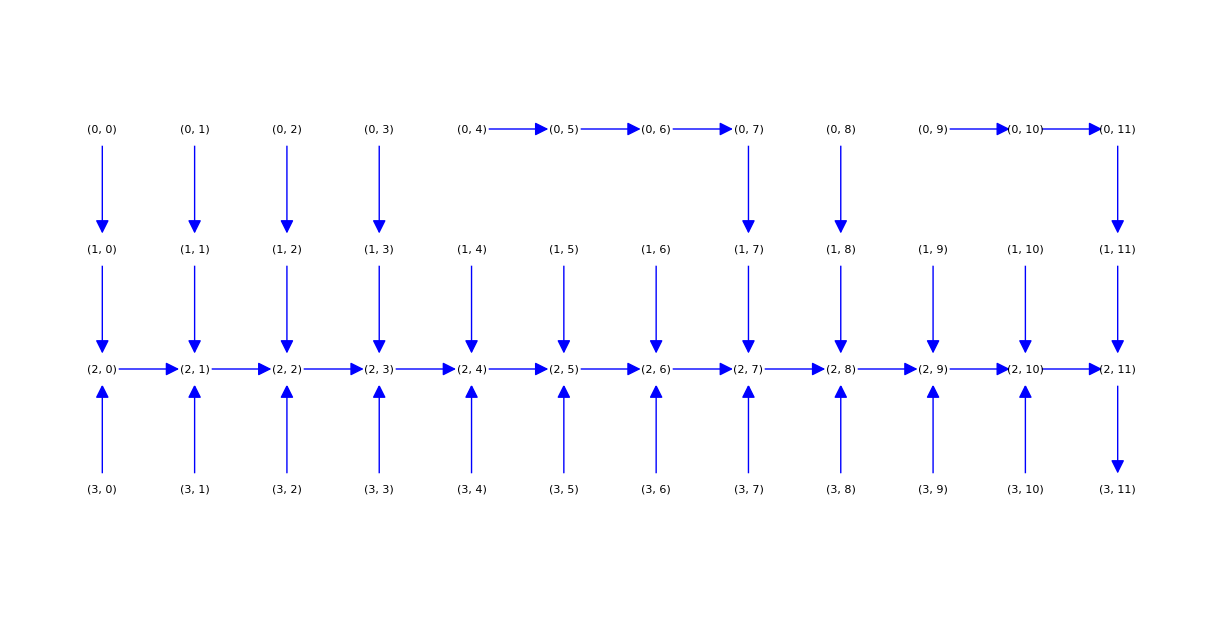

In [31]:
print_optimal_policy(q_learn_agent.optimal_policy())

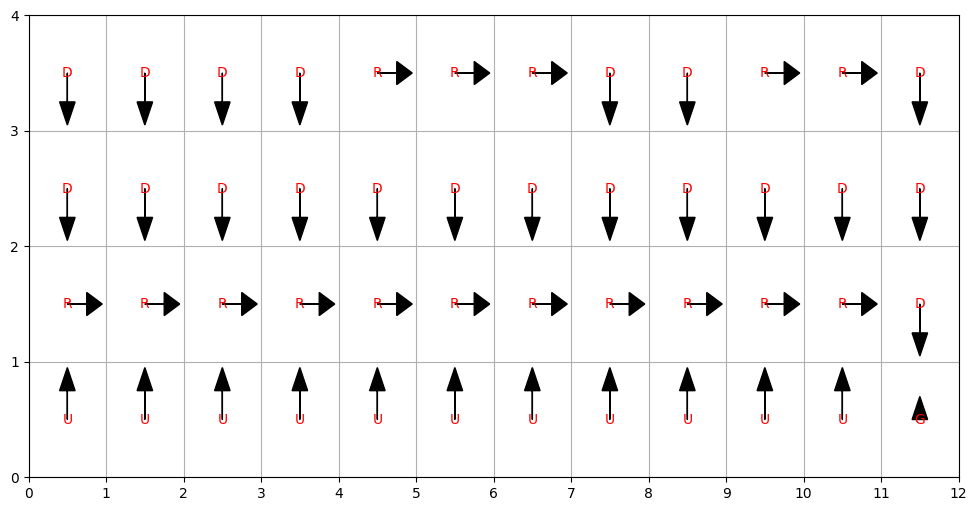

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Define the environment
class CliffWalking:
    def __init__(self):
        self.WORLD_HEIGHT = 4
        self.WORLD_WIDTH = 12
        self.START = [3, 0]
        self.GOAL = [3, 11]

# Function to print the optimal policy


# Example usage with your optimal policy
optimal_policy = [
    ['D', 'D', 'D', 'D', 'R', 'R', 'R', 'D', 'D', 'R', 'R', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D'],
    ['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
]

print_optimal_policy(optimal_policy)